# Prediction

TODO: some description

---

## Imports:

In [1]:
import os
import pandas as pd
import numpy as np
from typing import Tuple

import lightgbm as lgb

from sklearn import metrics
from sklearn.model_selection import train_test_split

In [2]:
import mvi.utils as mvi_utils

## Config

In [3]:
COLS_IGNORE = [
    "id", 
    "timestamp",
]

TARGET_COL = "price_doc"

In [4]:
DATA_DIR_PATH = "../data/"

PATH_TRAIN = os.path.join(DATA_DIR_PATH, "train_preprocessed.csv")
PATH_TEST = os.path.join(DATA_DIR_PATH, "test_preprocessed.csv")
PATH_SYNTH = os.path.join(DATA_DIR_PATH, "train_synth_ctgan.csv")

## Prepare data

### Read

In [5]:
def _read_data_preprocessed(path: str) -> pd.DataFrame:
    return pd.read_csv(path, parse_dates=["timestamp"])

In [6]:
df_train = _read_data_preprocessed(PATH_TRAIN)
df_test = _read_data_preprocessed(PATH_TEST)
df_synth = _read_data_preprocessed(PATH_SYNTH).sample(df_train.shape[0], random_state=42)

### Concat

Create the augmented dataframe by concatenating real 

In [7]:
df_aug = pd.concat([df_train, df_synth])

### Check

Check schemas:

In [8]:
mvi_utils.check_schema(df_train, df_test, df_synth, df_aug)

n_rows_sum = df_train.shape[0] + df_synth.shape[0]
n_rows_aug = df_aug.shape[0]
assert n_rows_sum == n_rows_aug, f"number of rows does not match: {n_rows_sum} != {n_rows_aug}"

---

## Isolate target

In [9]:
def _split_features_target(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
    """Splits data into features (X) and target (y)"""
    return df.drop([TARGET_COL, *COLS_IGNORE], axis=1), df.loc[:, TARGET_COL] 

In [10]:
X_train_real, y_train_real = _split_features_target(df_train)
X_train_aug, y_train_aug = _split_features_target(df_aug)
X_test, y_test = _split_features_target(df_test)

## Training

In [11]:
def _train_model(features: pd.DataFrame, target: pd.Series, model_class=lgb.LGBMRegressor, hparams: dict = None):
    """Trains model on provided dataset"""
    if hparams is None:
        # use all default hyperparameters
        hparams = {}
    
    model = model_class(**hparams)
    model_fit = model.fit(features, target)
    
    return model_fit

In [12]:
lgbm_regressor_real = _train_model(X_train_real, y_train_real)
lgbm_regressor_aug = _train_model(X_train_aug, y_train_aug)

## Predictions

In [13]:
def _predict(df_features: pd.DataFrame, model): 
    """Predicts target using the passed model"""
    df_prediction = model.predict(df_features)
    
    return pd.Series(df_prediction, name=f"{TARGET_COL}_predicted")

In [14]:
pred_real = _predict(X_test, lgbm_regressor_real)
pred_aug = _predict(X_test, lgbm_regressor_aug)

## Evaluation 

Simple RMSE

In [15]:
def _evaluate(prediction: pd.Series, target: pd.Series):
    """Evaluates predictions"""
    return np.sqrt(metrics.mean_squared_error(prediction, target))

In [16]:
rmse_real = _evaluate(pred_real, y_test)
rmse_aug = _evaluate(pred_aug, y_test)

change = 1 - (rmse_aug / rmse_real)
print(f"{rmse_real=:,.0f}, {rmse_aug=:,.0f} (improvement: {change:.2%})")

rmse_real=1,623,850, rmse_aug=1,695,546 (improvement: -4.42%)


---

## Perspective

In [17]:
mae_real = metrics.mean_absolute_error(pred_real, y_test)

In [18]:
mae_real / y_test.mean()

0.16913739526780341

<AxesSubplot: >

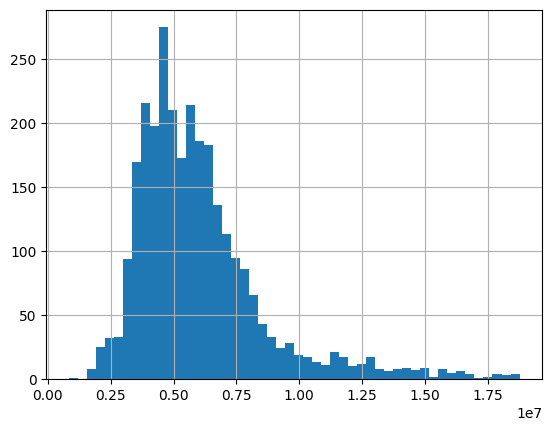

In [19]:
y_test.hist(bins=50)